In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from scipy import ndimage as ndi

from skimage import (
    exposure, io, morphology, color, feature, filters, util, segmentation
)
import math
#import napari
#from napari.utils import nbscreenshot
from scipy import signal
from skimage.filters import threshold_multiotsu
from skimage.filters import try_all_threshold, gaussian
from skimage.morphology import disk
from skimage.filters import threshold_li
from skimage import measure
import pandas as pd
import os
#import PyDIP as dip
import math
import re
from glob import glob
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.segmentation import random_walker, clear_border
from scipy import ndimage
from skimage.measure import label, regionprops, regionprops_table
from skimage.exposure import histogram

In [26]:
def slice(im3d):
    stack_size = im3d.shape[0]
    hist=[]
    for i in range(stack_size):
        hist.append(im3d[i,:,:].mean())
    plt.plot(range(stack_size),hist, '.-')
    #if len(signal.argrelextrema(np.array(hist), np.greater)) <= 2:
    grad1 = np.gradient(hist)
    peaks, ups = signal.find_peaks(grad1,max(grad1)*0.1)
    peaks2, ups2 = signal.find_peaks(hist,max(hist)*0.1)
    #plt.vlines([maximums],0,max(hist), colors='r')
    plt.vlines([peaks2],0,max(hist), colors='b')
    chosen=[]
    for i in range(stack_size):
        if hist[i] >= (ups['peak_heights'][0]+2*ups2['peak_heights'][0])/3:
            plt.vlines(i,0,max(hist), colors='y')
            chosen.append(i)
    return chosen

In [27]:
def slice_manual(im3d,start,stop):
    stack_size = im3d.shape[0]
    hist=[]
    for i in range(stack_size):
        hist.append(im3d[i,:,:].mean())
    plt.plot(range(stack_size),hist, '.-')
    #if len(signal.argrelextrema(np.array(hist), np.greater)) <= 2:
    grad1 = np.gradient(hist)
    peaks, ups = signal.find_peaks(grad1,max(grad1)*0.1)
    peaks2, ups2 = signal.find_peaks(hist,max(hist)*0.1)
    #plt.vlines([maximums],0,max(hist), colors='r')
    plt.vlines([peaks2],0,max(hist), colors='b')
    chosen = range(start,stop)
    for i in chosen:
        plt.vlines(i,0,max(hist), colors='y')
    return chosen

In [28]:
def display(im3d, cmap="gray", step=1, chosen = None):
    if chosen is None: 
        chosen = []
    stack_size = im3d.shape[0]
    cols = 5
    rows = math.ceil((stack_size/cols))
    
    h , axes = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols, 3*rows))
    #print(h)
    #p1 = get(h,'Position')
    #annotation('rectangle',p1,'FaceAlpha',.2,'FaceColor','red','EdgeColor','red') 
    vmin = im3d.min()
    vmax = im3d.max()
    enum = 0
    for ax, image in zip(axes.flatten(), im3d[::step]):
        ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
        if enum in chosen:
            for axis in ['top','bottom','left','right']:
                #ax.spines[axis].set_linewidth(0.5)
                ax.spines[axis].set_color("red")
                ax.spines[axis].set_linewidth(5)
        ax.set_xticks([])
        ax.set_yticks([])
        enum += 1
    #plt.savefig('foo.png')
    

In [29]:
def display_slice(im, cmap="gray", step=1, chosen = None, savefig = False):
    h , axes = plt.subplots(1,1)
    vmin = im.min()
    vmax = im.max()
    enum = 0
    axes.imshow(im, cmap=cmap, vmin=vmin, vmax=vmax)

In [30]:
ResultsDir = "/groups/gerlich/experiments/Experiments_005700/005765/sororin_knockdown_quantification/"

In [31]:
#Define function to threshold a field of cells using MultiOtsu thresholding from skimage
#apply watershedding and then extract features >>> final output is a dataframe

#To do >>> extract metadata automatically using TIFFFILE

In [ ]:
#Normalise to background and mean nuclear Sororin fluorescence of control cells. Background calculated by measuring mean Sororin fluorescence in non-cell regions of 5 control cells 

#rep2 pos2-6 10, 2.854
#rep1 pos4-1, 2.828
#rep1 pos3-1, 2.806
#rep1 pos15-1, 2.862
#rep2 pos1-5, 2, 2.851

#mean background = 2.84

In [32]:
def image_stdev(region, intensities):
    # note the ddof arg to get the sample var if you so desire!
    return np.std(intensities[region], ddof=1)

In [33]:
pixel_size = (14.1562)
#this is the number of pixels per micron, change the pixel size according to your specific image
scaling_factor = pixel_size**2




def threshold_field(images):

    
    #Set up variables as empty dataframes
    all_hoechst = pd.DataFrame()
    all_sororin = pd.DataFrame()

    #read in files
    for image in images:
        data = io.imread(image)
        #select channels, wapl = channel3, Scc1 = channel2, Hoechst = channel 1 in this image
        hoechst = data[:,:,0]
        sororin = data[:,:,2]
        #display_slice(wapl_ha)
        
        #hoechst = hoechst - 0.135
         
          
        #hoechst[hoechst < 10] = 0
        
        
        sigma = 3.0

        # apply Gaussian blur, creating a new image
        blurred = filters.gaussian(
        hoechst, sigma=(sigma, sigma), truncate=3.5, multichannel=True)
        #display_slice(blurred)


        #threshold the hoechst_channel using multiotsu thresholding
        thresh = threshold_li(blurred)
        #mask = hoechst > thresh
        
        binary_mask = morphology.binary_closing(blurred > thresh, disk(15)) 
        
        #binary_mask = ndimage.binary_fill_holes(blurred).astype(int)
        
        cleared = clear_border(binary_mask)
        remove_debris = morphology.remove_small_objects(cleared, 35000)
        

        #optimise thresholding parameters for this dataset

        #igher_threshold = 60
        #ilt = hoechst > higher_threshold

        #moother_filt = filters.rank.mean(util.img_as_ubyte(remove_debris),
                                      #orphology.disk(4))

        #inal_thresh = smoother_filt > 60

        #apply watershedding to distinguish cells which are thresholded as a single cell when in reality there are two
        distance = ndi.distance_transform_edt(remove_debris)

        local_max_coords = feature.peak_local_max(distance, min_distance=65)
        local_max_mask = np.zeros(distance.shape, dtype=bool)
        local_max_mask[tuple(local_max_coords.T)] = True
        markers = measure.label(local_max_mask)

        segmented_cells = segmentation.watershed(-distance, markers, mask=remove_debris)
        
        remove_small_masks = morphology.remove_small_objects(segmented_cells, 35000)
        
        segmented_cells = remove_small_masks

        #this is the number of pixels per micron, change the pixel size according to your specific image
        #Generate labels, each thresholded object becomes a label
        pixel_size = (14.1562)
        scaling_factor = pixel_size**2

        #Generate labels, each thresholded object becomes a label
        labels = measure.label(segmented_cells)
        properties = measure.regionprops(labels)

        #choose which features to extract and extract features for the first channel. Calculate nuclear area

        properties_hoechst = ["area", "mean_intensity"]
        output_hoechst = pd.DataFrame(regionprops_table(labels, hoechst, 
             properties=properties_hoechst))
        #rename columns
        output_hoechst = output_hoechst.rename(columns={"area":"area_pixels"})
        output_hoechst = output_hoechst.rename(columns={"mean_intensity":"mean_hoechst"})

        #get nuclear area in microns instead of pixels and then calculate total intensity per nucleus
        output_hoechst["nuclear_area_microns"] = output_hoechst["area_pixels"]/scaling_factor
        #calculate total intensity 
        output_hoechst["total_hoechst"] = output_hoechst["nuclear_area_microns"] * output_hoechst["mean_hoechst"]

        #extract info for second channel, area is the same as for the first channel
        properties_sororin = ["mean_intensity"]
        #extra_properties = ["image_stdev"]
        output_sororin = pd.DataFrame(regionprops_table(labels, sororin, 
             properties=properties_sororin))
        output_sororin = output_sororin.rename(columns={"mean_intensity":"mean_sororin"})
        #output_scc1 = output_scc1.rename(columns={"image_stdev":"std_scc1"})
        output_sororin["total_nuclear_sororin"] = output_hoechst["nuclear_area_microns"] * output_sororin["mean_sororin"]

        props_hoechst = pd.DataFrame(regionprops_table(labels, hoechst, extra_properties=[image_stdev]))
        
        output_hoechst["std_hoechst"] = props_hoechst["image_stdev"]       
        
        props_sororin = pd.DataFrame(regionprops_table(labels, sororin, extra_properties=[image_stdev]))
        
        output_sororin["std_sororin"] = props_sororin["image_stdev"]
        
        #for i in range(len(properties)):
            #print(properties[i].area)
        
        #Display thresholding to check if it is appropriate
        #display_slice(hoechst)
        #display_slice(final_thresh)
        #display_slice(segmented_cells)
        image_name = image
        print(image_name)
        fig, ax = plt.subplots(ncols=4, figsize=(25, 5))
        ax[0].imshow(hoechst, cmap='gray')
        ax[0].set_title('Original Image')
        ax[0].axis('off')
        ax[1].imshow(blurred, cmap='gray')
        ax[1].set_title('Blurred Image')
        ax[1].axis('off')
        ax[2].imshow(remove_debris, cmap='gray')
        ax[2].set_title('Threshold binary mask')
        ax[2].axis('off')
        ax[3].imshow(color.label2rgb(segmented_cells, bg_label=0))
        ax[3].set_title('Segmented nuclei after watershedding')
        ax[3].axis('off')
        plt.show()

        all_hoechst = all_hoechst.append(output_hoechst)
        all_sororin = all_sororin.append(output_sororin)
       
        #print(output_hoechst)
        #print(output_scc1)|
        #print(all_hoechst)
        #print(all_scc1)
        all_data = pd.concat([all_hoechst, all_sororin], axis=1)
        all_data["image_name"] = image_name
        #print(all_data)
    
    #reorder columns for final output
    final_df = all_data[["nuclear_area_microns", "mean_hoechst", "mean_sororin", "total_hoechst", "total_nuclear_sororin", "std_hoechst", "std_sororin"]]
    #exclude_mitotic_cells
    final_df = final_df.loc[(final_df.nuclear_area_microns > 100)]
    #threshold = (final_df.mean_smc4.mean())*2
    #final_df = final_df.loc[final_df.mean_smc4 < threshold]
    final_df["coeff_variance_hoechst"] = final_df["std_hoechst"]/final_df["mean_hoechst"]
    final_df["coeff_variance_sororin"] = final_df["std_sororin"]/final_df["mean_sororin"]
    final_df["condition"] = "16nm_sor_sirna"

    #output final dataframe to the results directory
    #final_df.to_csv(os.path.join(ResultsDir + "test.csv"), index = False)
    final_df.to_csv(os.path.join(ResultsDir + "16nm_sor_sirna_wapl_dep_1802.csv"), index = False)
    return final_df


/tmp/ipykernel_17587/343138571.py:32: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0.Please use `channel_axis` instead.
  blurred = filters.gaussian(


1802_wapl_dep_sor_si_16nm_rep2_pos16-23 #8.tif


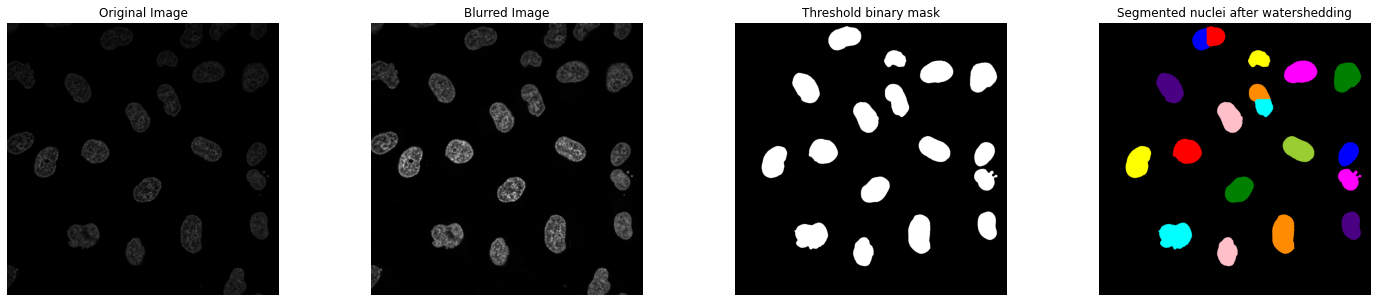

1802_wapl_dep_sor_si_16nm_rep1_pos1-8 #1.tif


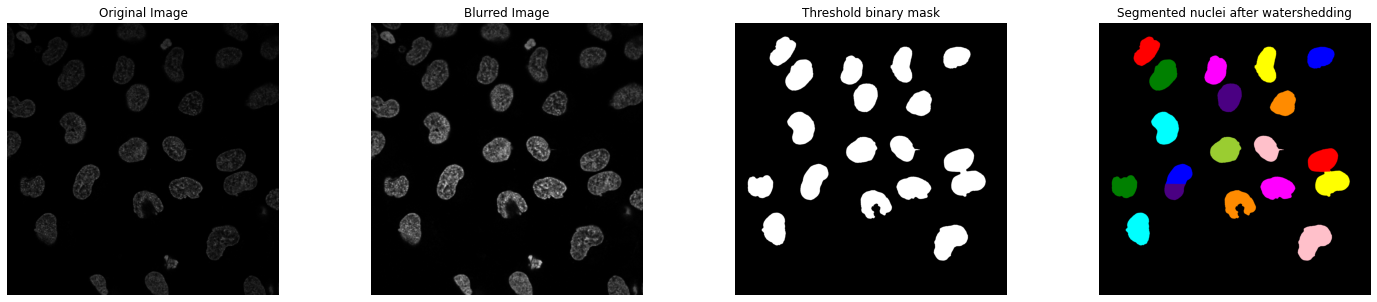

1802_wapl_dep_sor_si_16nm_rep1_pos1-8 #2.tif


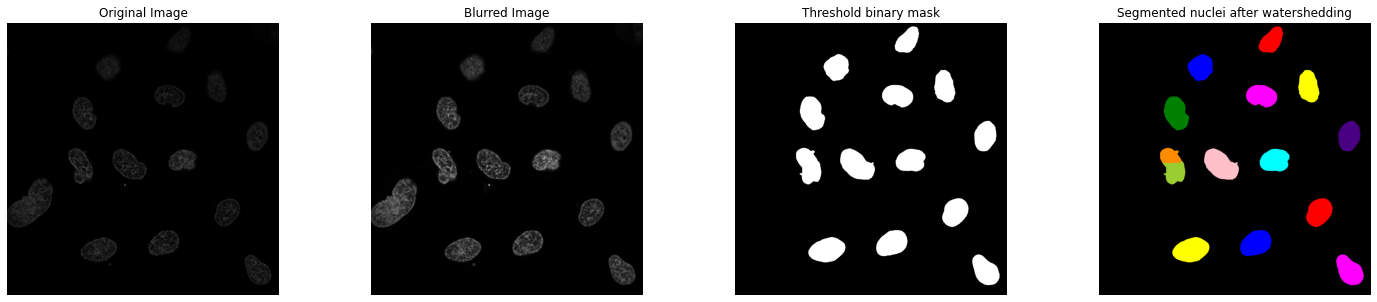

1802_wapl_dep_sor_si_16nm_rep1_pos1-8 #3.tif


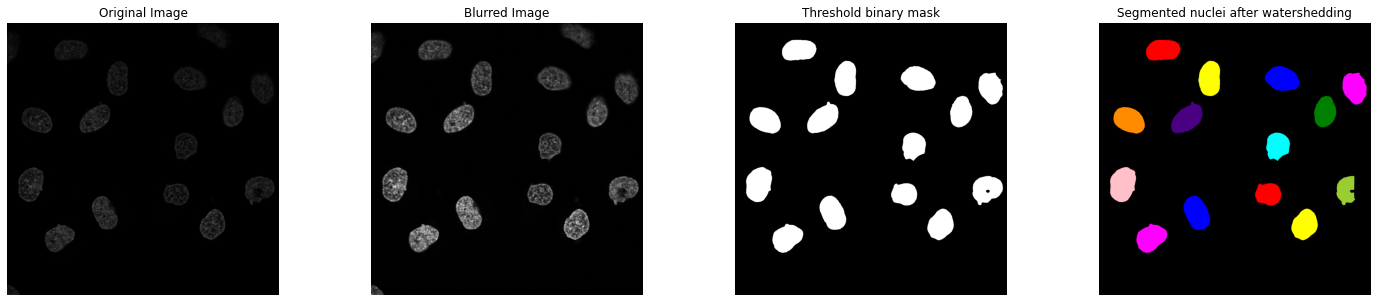

1802_wapl_dep_sor_si_16nm_rep1_pos1-8 #4.tif


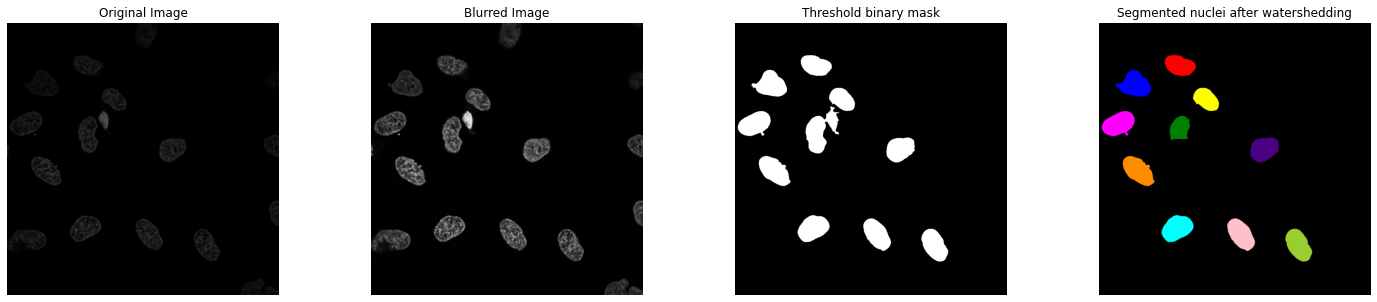

1802_wapl_dep_sor_si_16nm_rep1_pos1-8 #5.tif


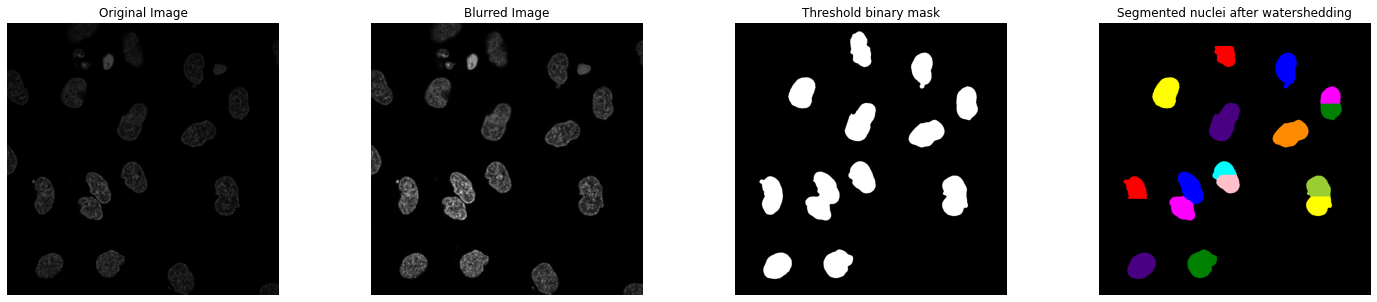

1802_wapl_dep_sor_si_16nm_rep1_pos1-8 #6.tif


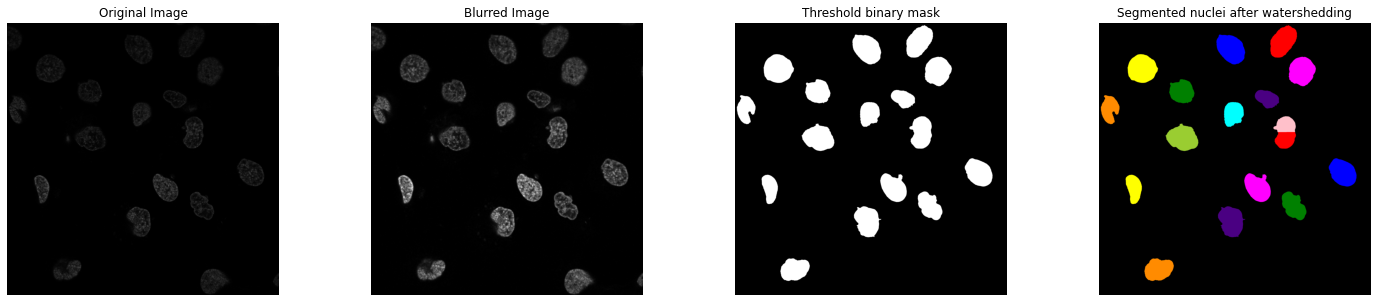

1802_wapl_dep_sor_si_16nm_rep1_pos1-8 #7.tif


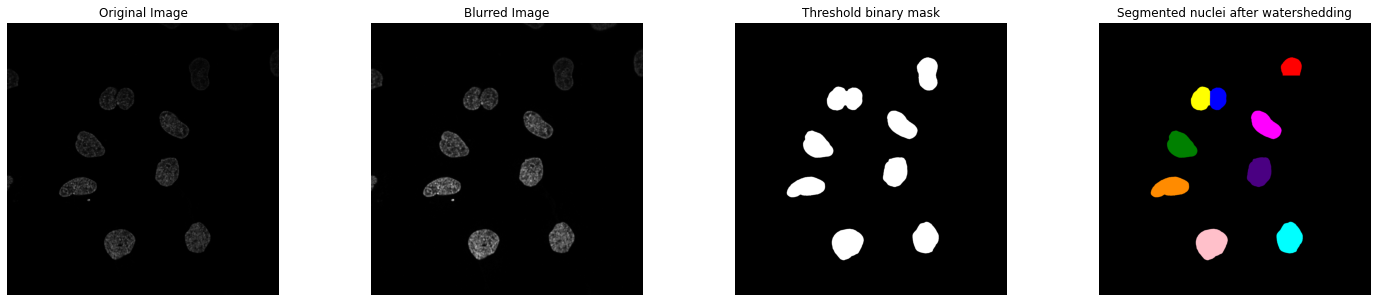

1802_wapl_dep_sor_si_16nm_rep1_pos1-8 #8.tif


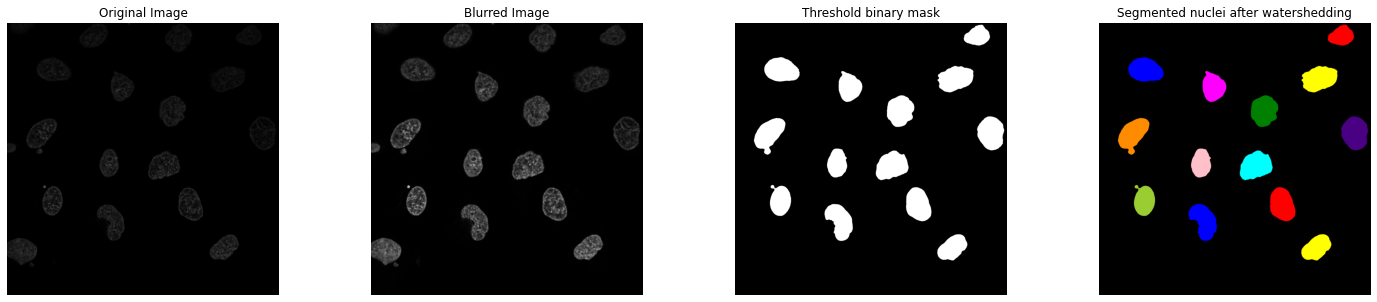

1802_wapl_dep_sor_si_16nm_rep1_pos9-13 #1.tif


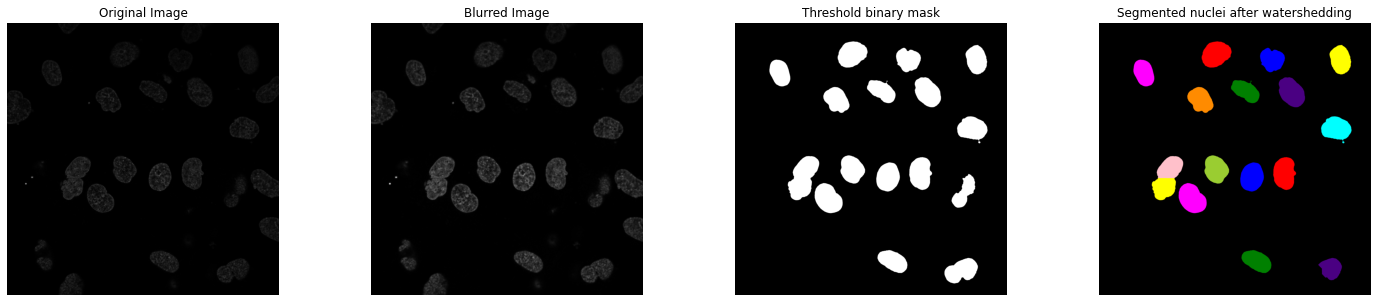

1802_wapl_dep_sor_si_16nm_rep1_pos9-13 #2.tif


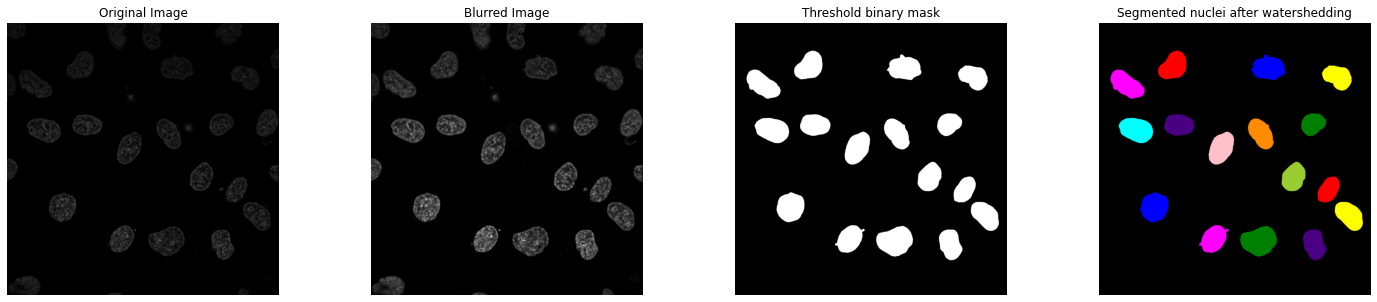

1802_wapl_dep_sor_si_16nm_rep1_pos9-13 #3.tif


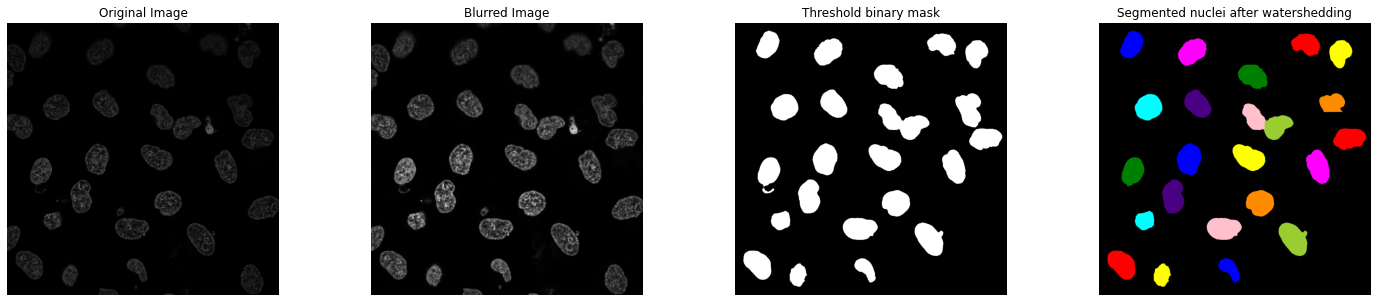

1802_wapl_dep_sor_si_16nm_rep1_pos9-13 #4.tif


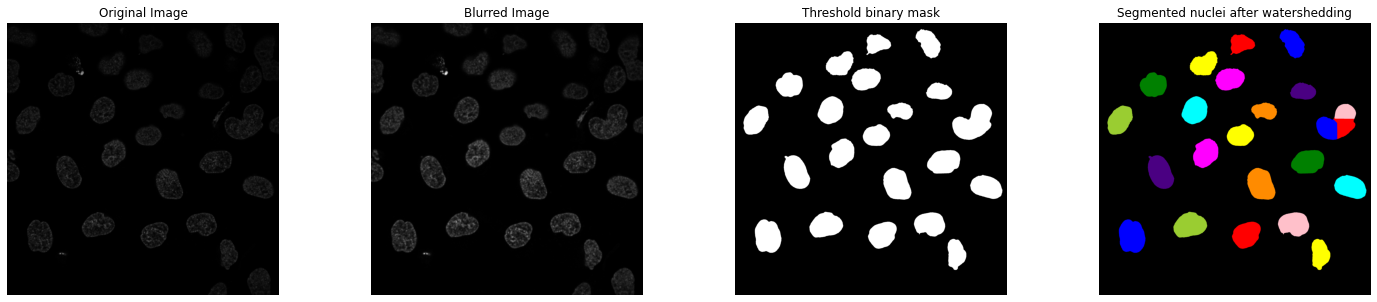

1802_wapl_dep_sor_si_16nm_rep1_pos9-13 #5.tif


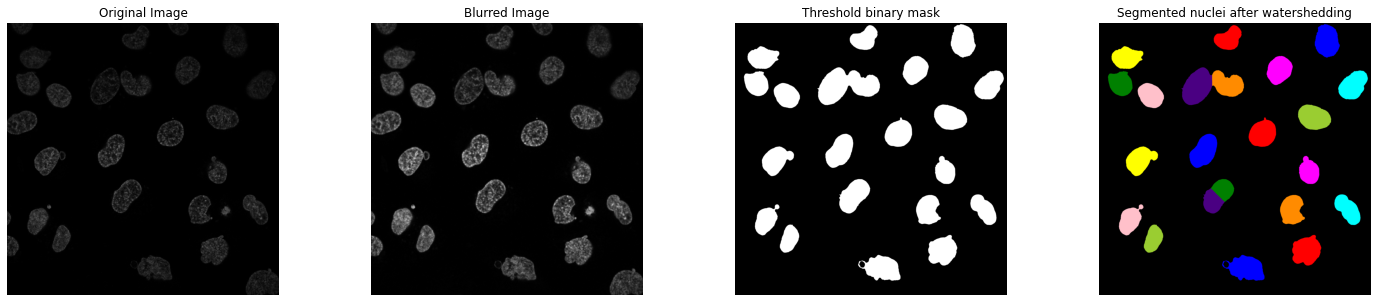

1802_wapl_dep_sor_si_16nm_rep1_pos14-18 #1.tif


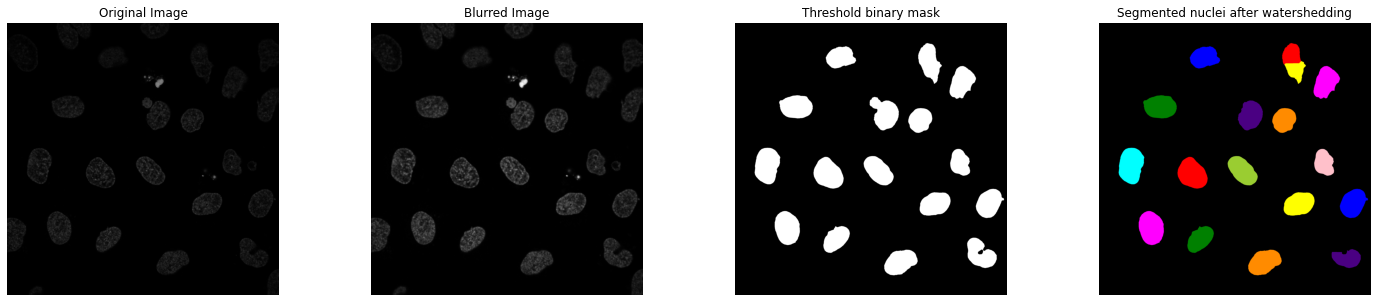

1802_wapl_dep_sor_si_16nm_rep1_pos14-18 #2.tif


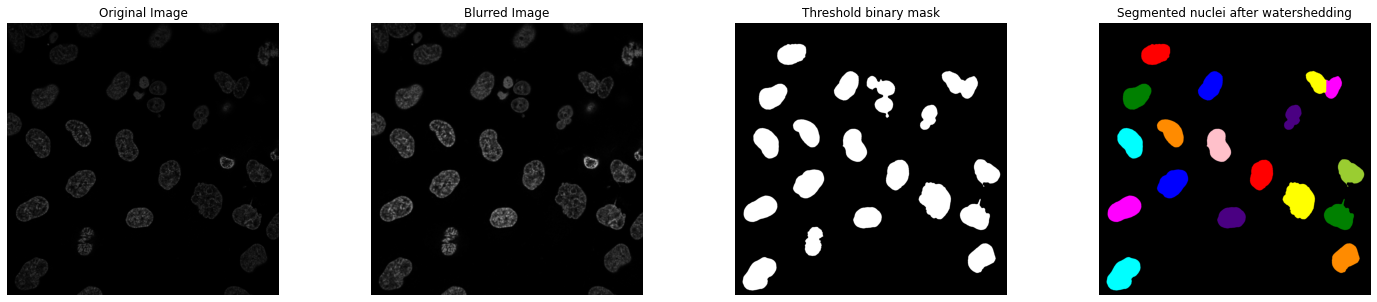

1802_wapl_dep_sor_si_16nm_rep1_pos14-18 #3.tif


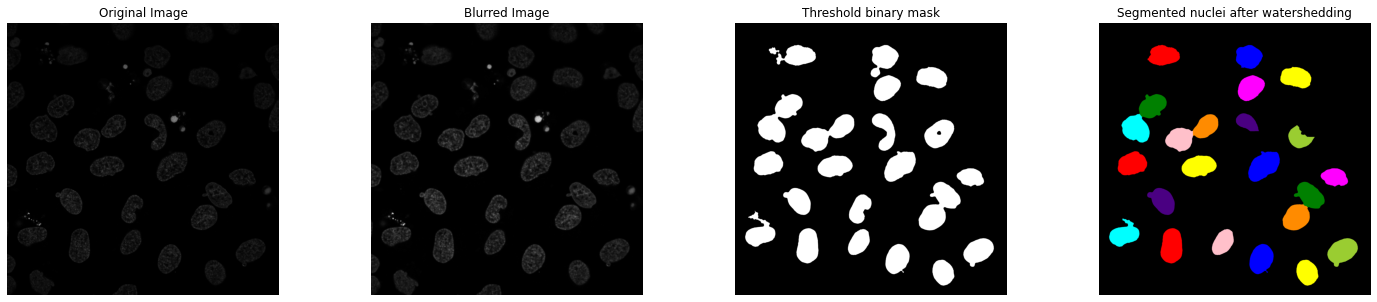

1802_wapl_dep_sor_si_16nm_rep1_pos14-18 #4.tif


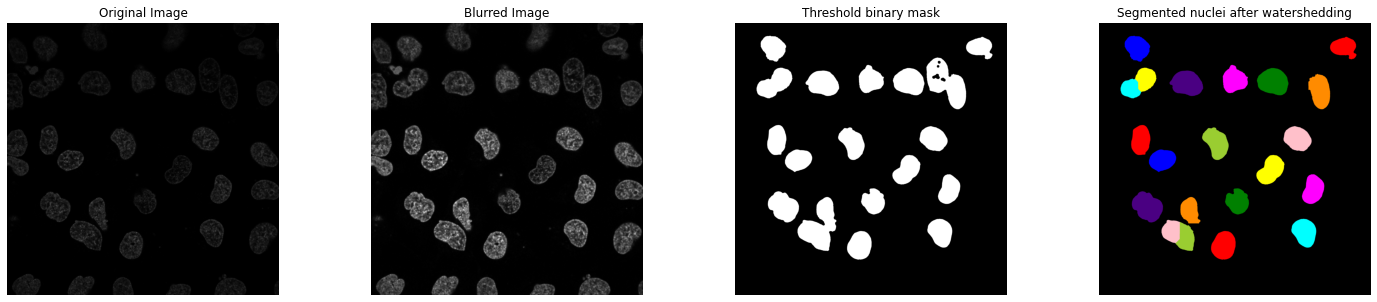

1802_wapl_dep_sor_si_16nm_rep1_pos14-18 #5.tif


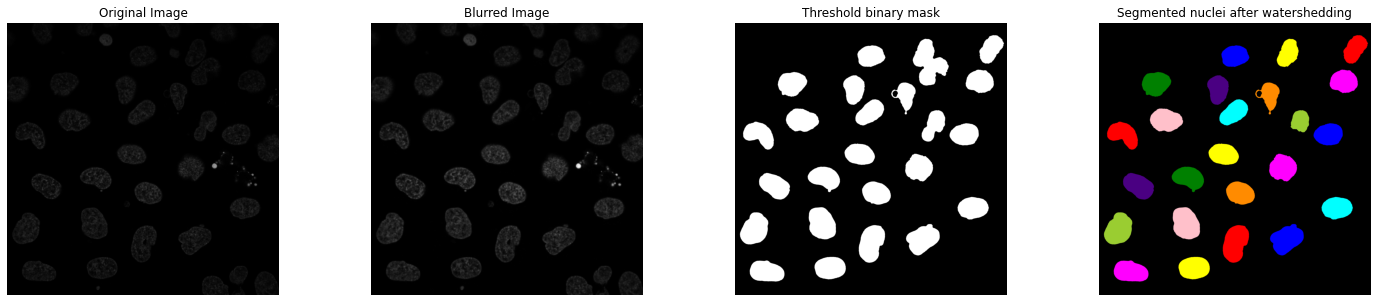

1802_wapl_dep_sor_si_16nm_rep1_pos14-18 #6.tif


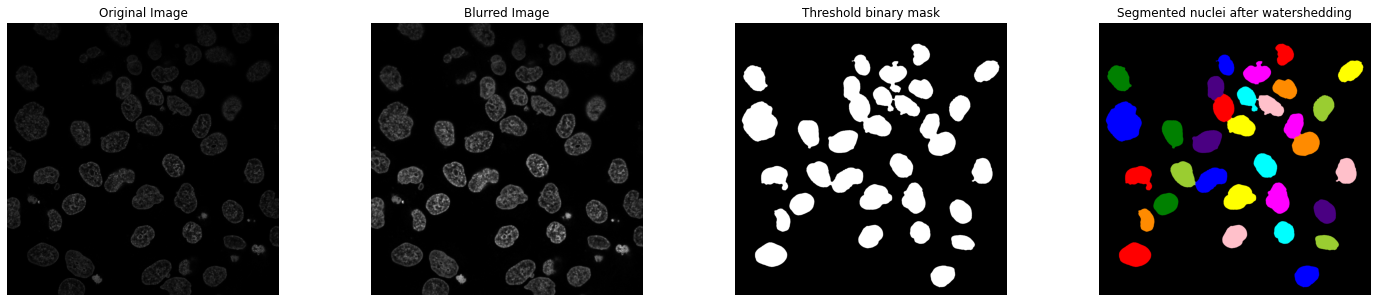

1802_wapl_dep_sor_si_16nm_rep1_pos19.tif


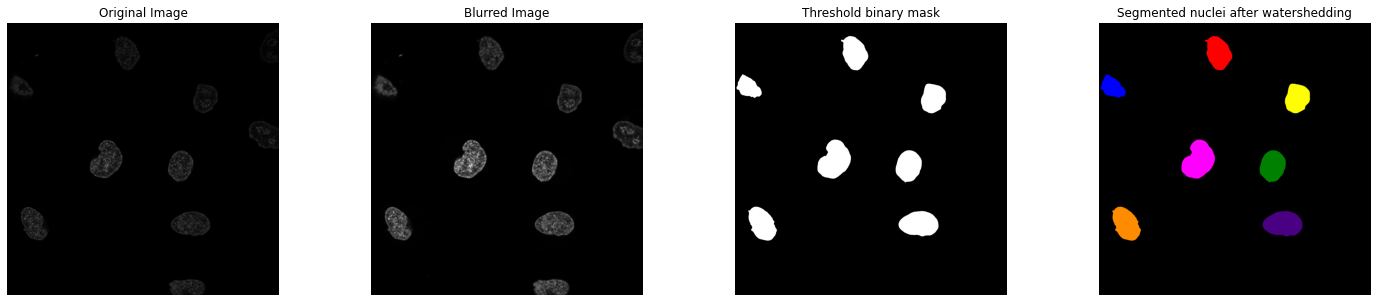

1802_wapl_dep_sor_si_16nm_rep1_pos20.tif


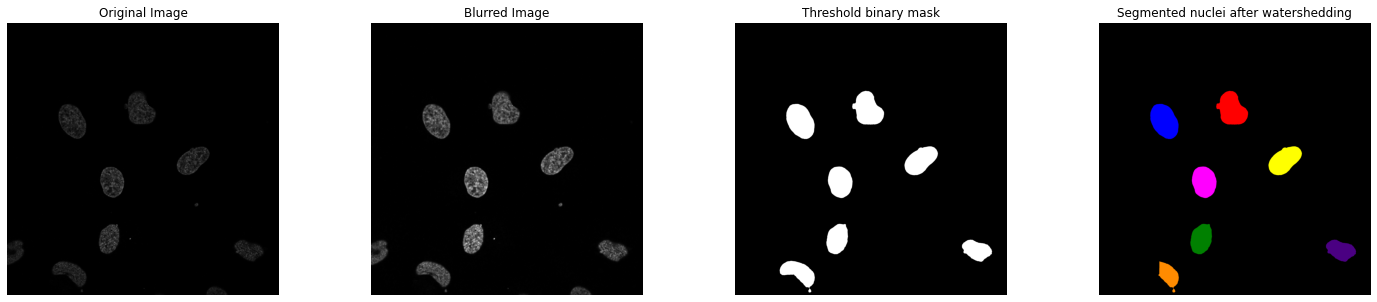

1802_wapl_dep_sor_si_16nm_rep1_pos21.tif


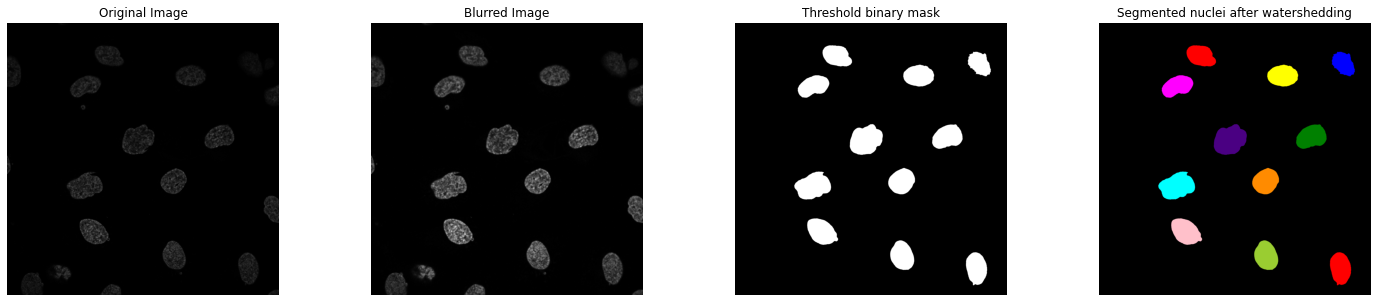

1802_wapl_dep_sor_si_16nm_rep2_pos1-3 #1.tif


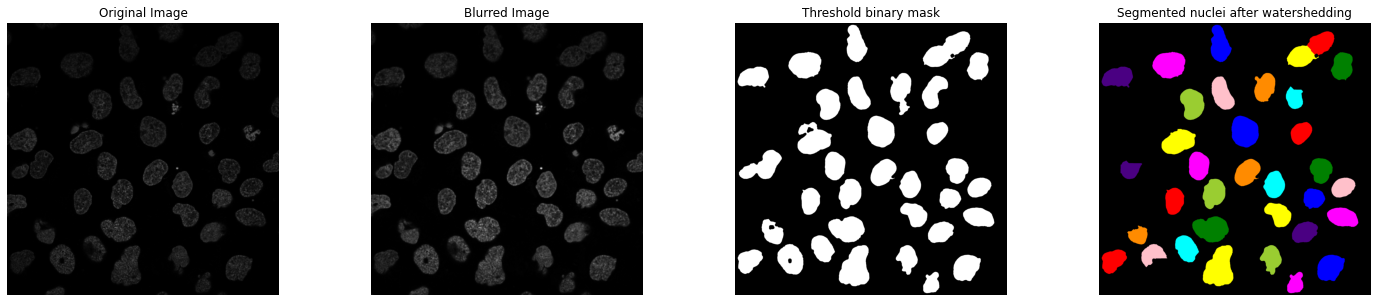

1802_wapl_dep_sor_si_16nm_rep2_pos1-3 #2.tif


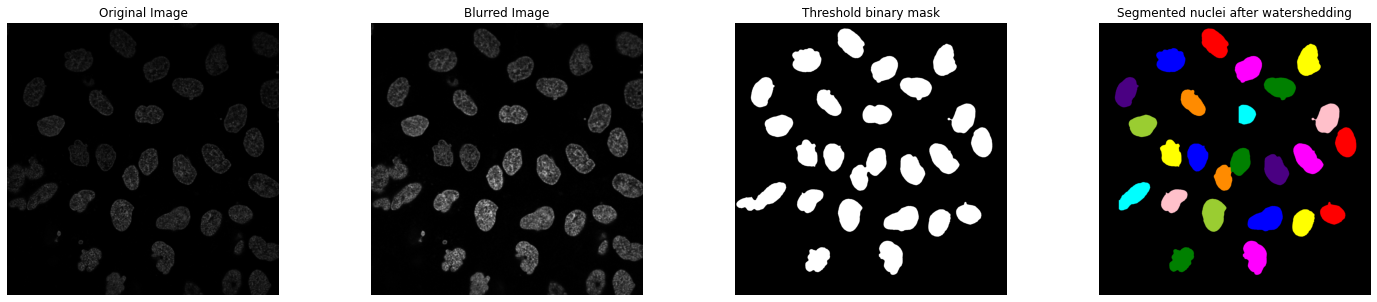

1802_wapl_dep_sor_si_16nm_rep2_pos1-3 #3.tif


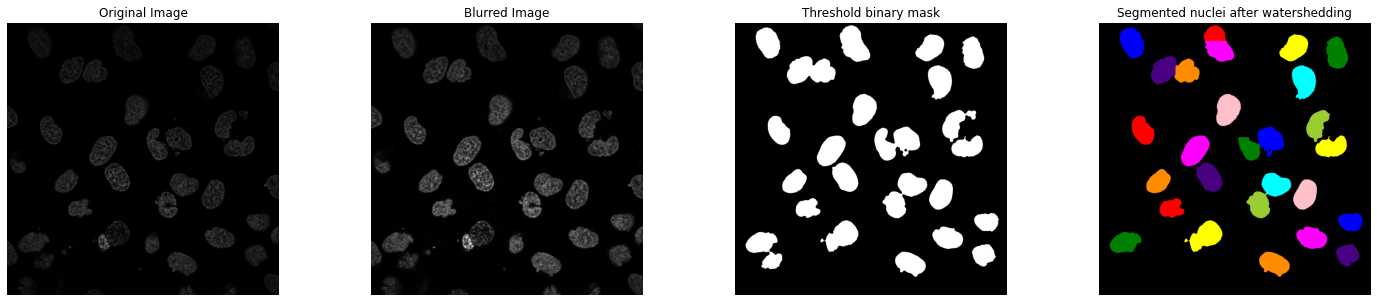

1802_wapl_dep_sor_si_16nm_rep2_pos4.tif


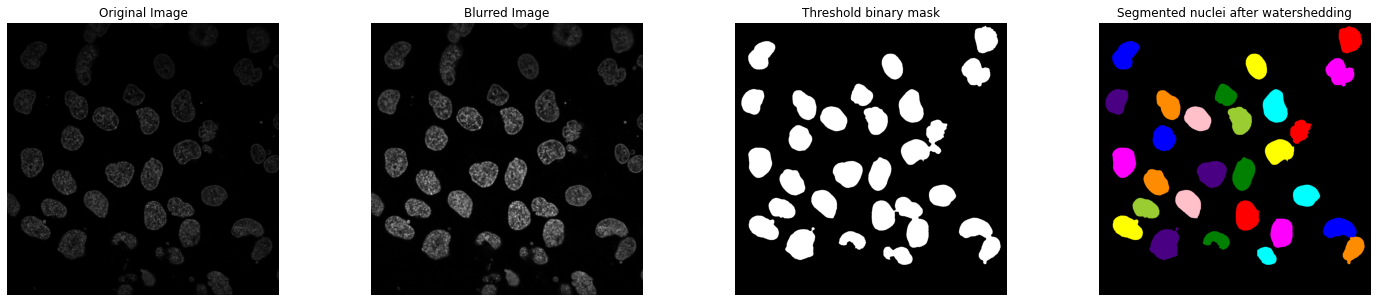

1802_wapl_dep_sor_si_16nm_rep2_pos5-6 #1.tif


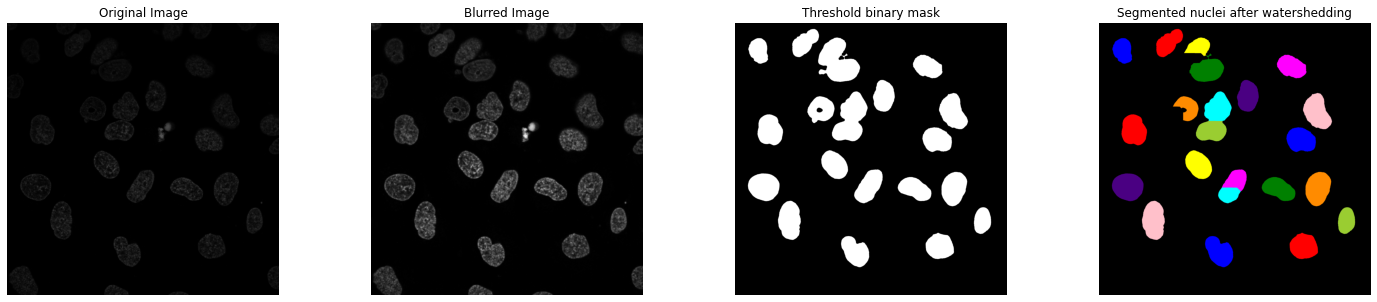

1802_wapl_dep_sor_si_16nm_rep2_pos5-6 #2.tif


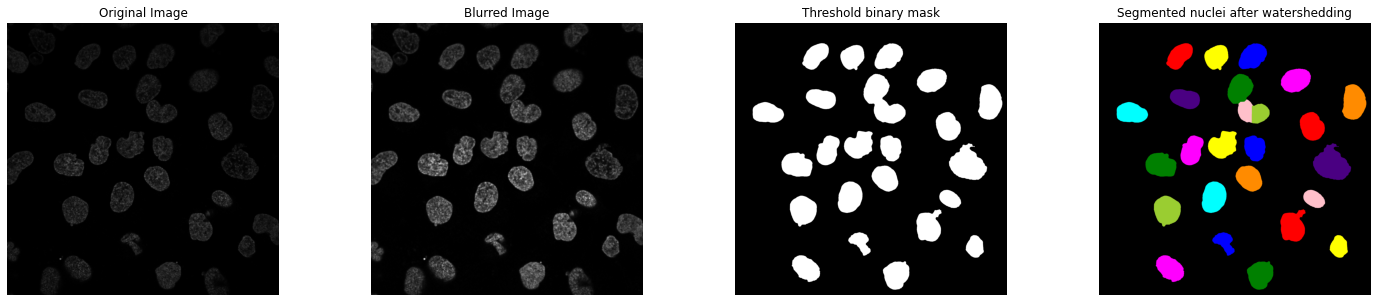

1802_wapl_dep_sor_si_16nm_rep2_pos7-8 #1.tif


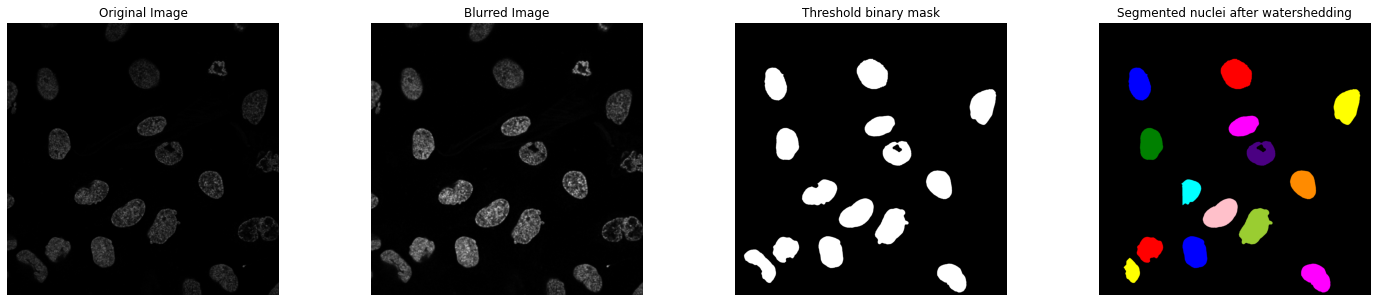

1802_wapl_dep_sor_si_16nm_rep2_pos7-8 #2.tif


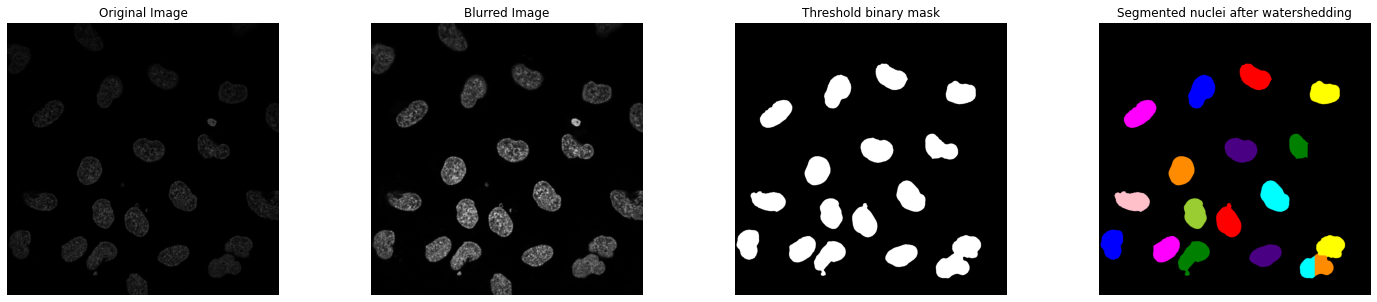

1802_wapl_dep_sor_si_16nm_rep2_pos8.tif


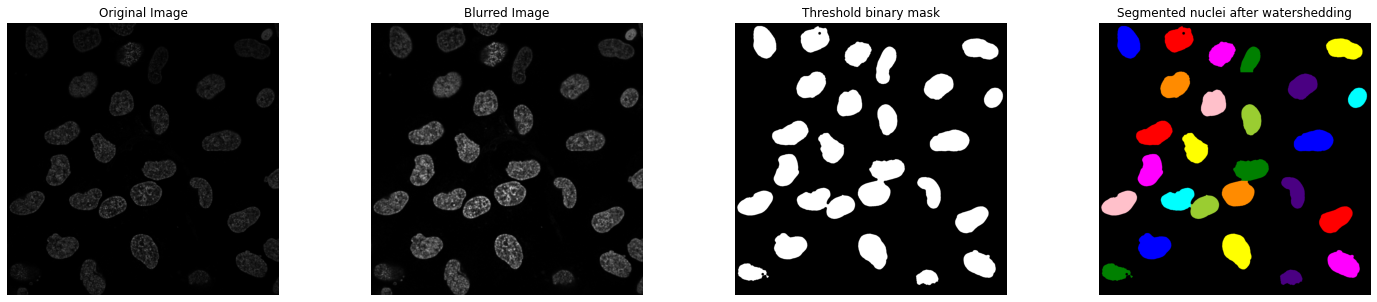

1802_wapl_dep_sor_si_16nm_rep2_pos9-11 #1.tif


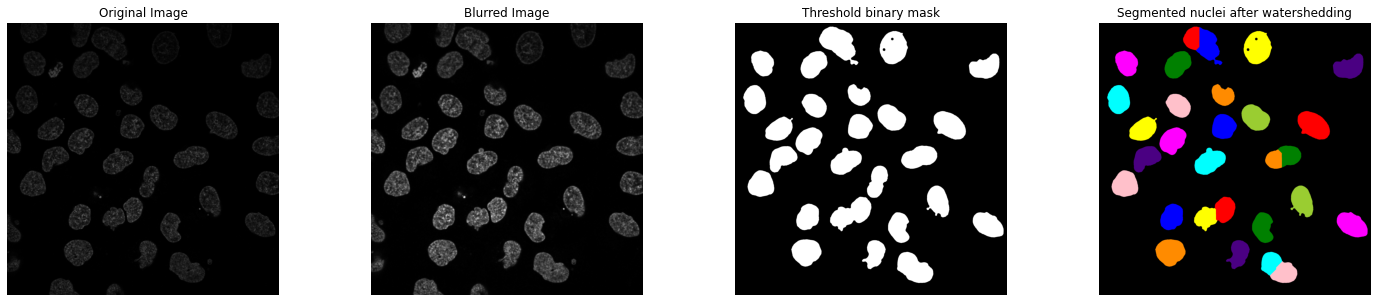

1802_wapl_dep_sor_si_16nm_rep2_pos9-11 #2.tif


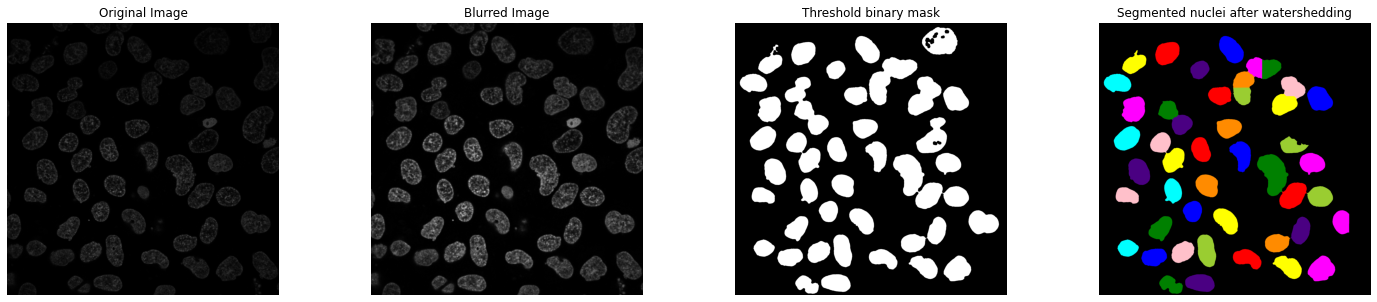

1802_wapl_dep_sor_si_16nm_rep2_pos9-11 #3.tif


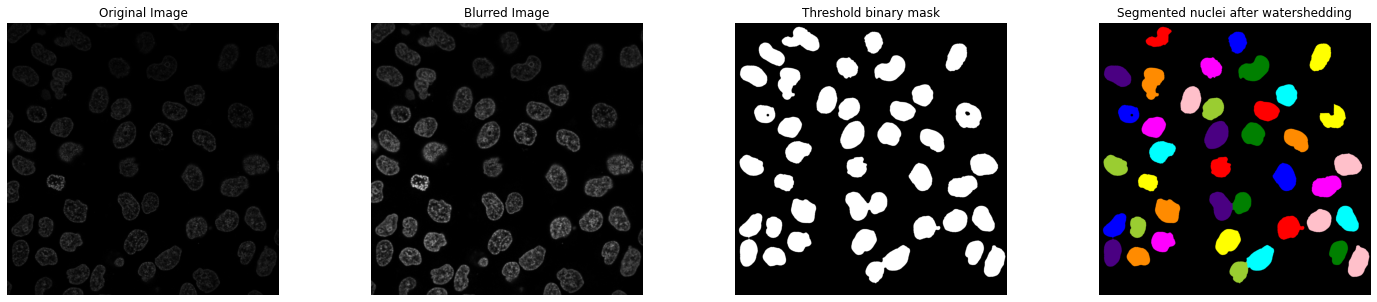

1802_wapl_dep_sor_si_16nm_rep2_pos12-15 #1.tif


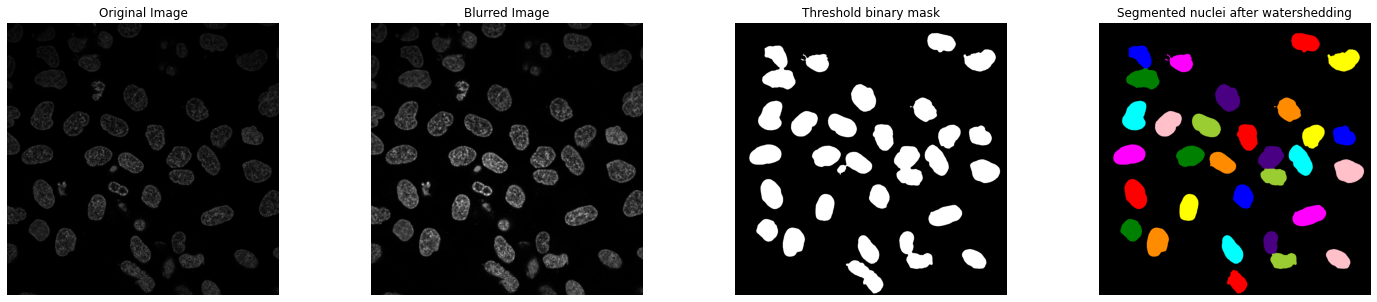

1802_wapl_dep_sor_si_16nm_rep2_pos12-15 #2.tif


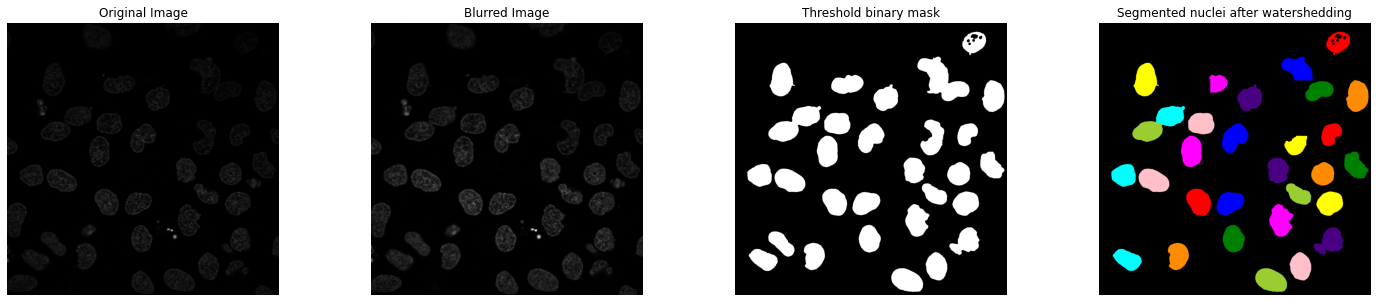

1802_wapl_dep_sor_si_16nm_rep2_pos12-15 #3.tif


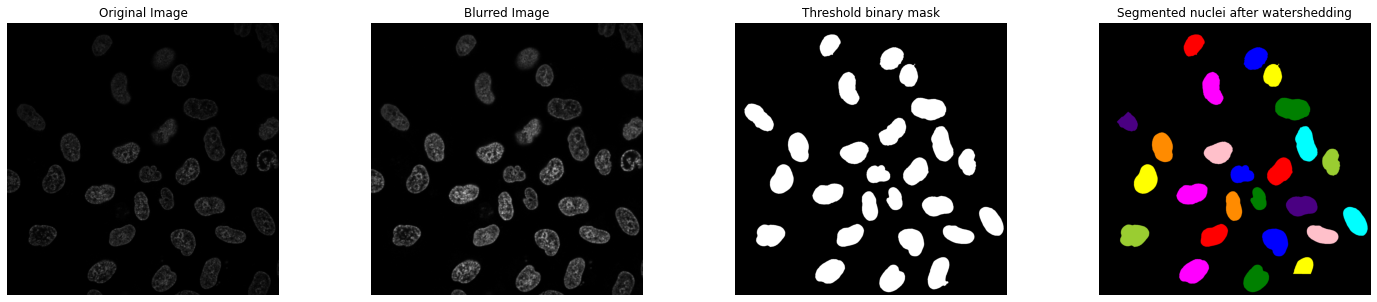

1802_wapl_dep_sor_si_16nm_rep2_pos12-15 #4.tif


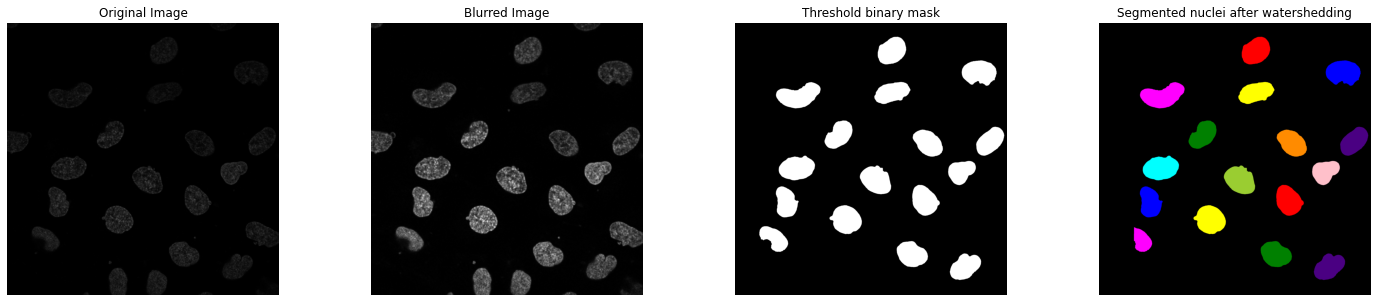

1802_wapl_dep_sor_si_16nm_rep2_pos16-23 #1.tif


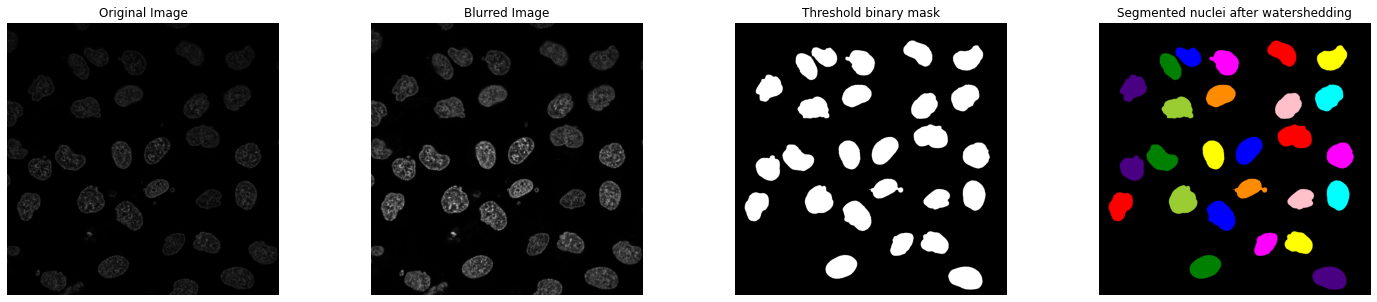

1802_wapl_dep_sor_si_16nm_rep2_pos16-23 #2.tif


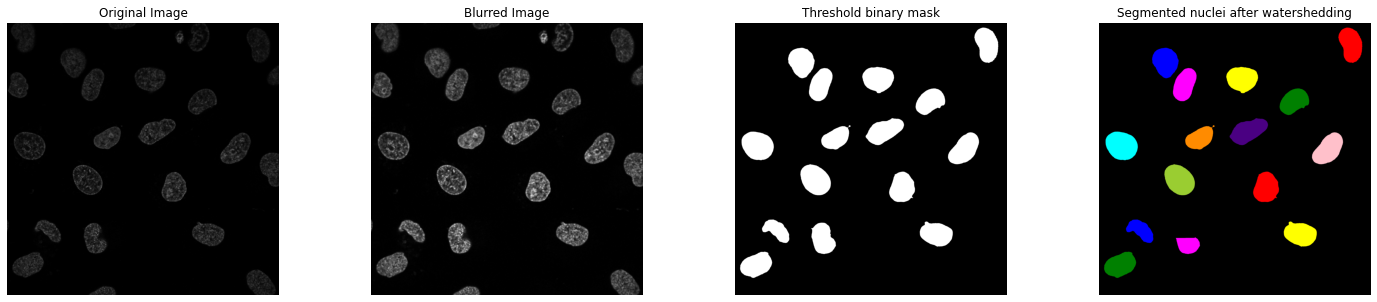

1802_wapl_dep_sor_si_16nm_rep2_pos16-23 #3.tif


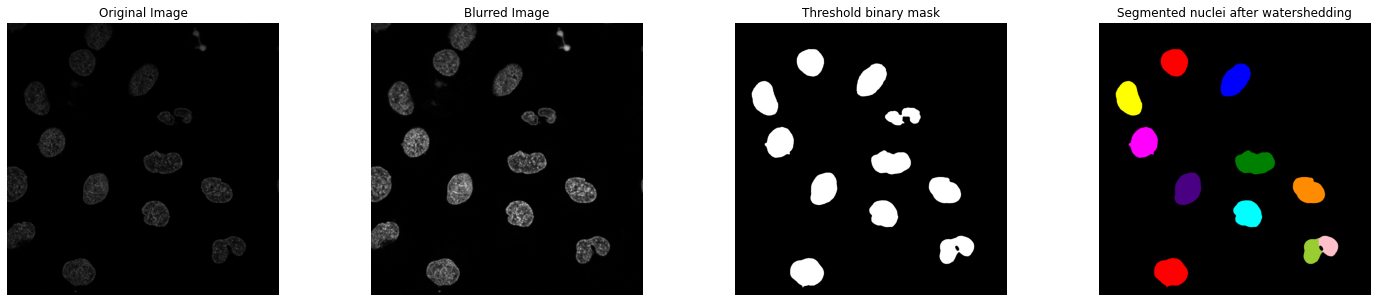

1802_wapl_dep_sor_si_16nm_rep2_pos16-23 #4.tif


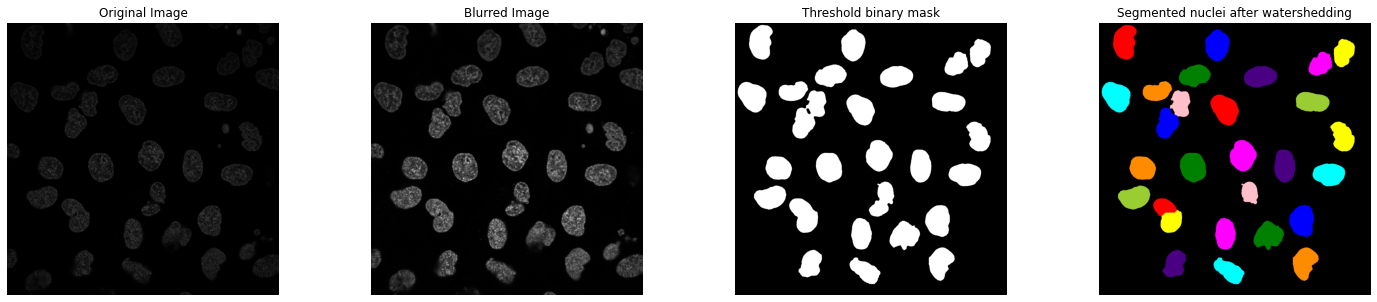

1802_wapl_dep_sor_si_16nm_rep2_pos16-23 #5.tif


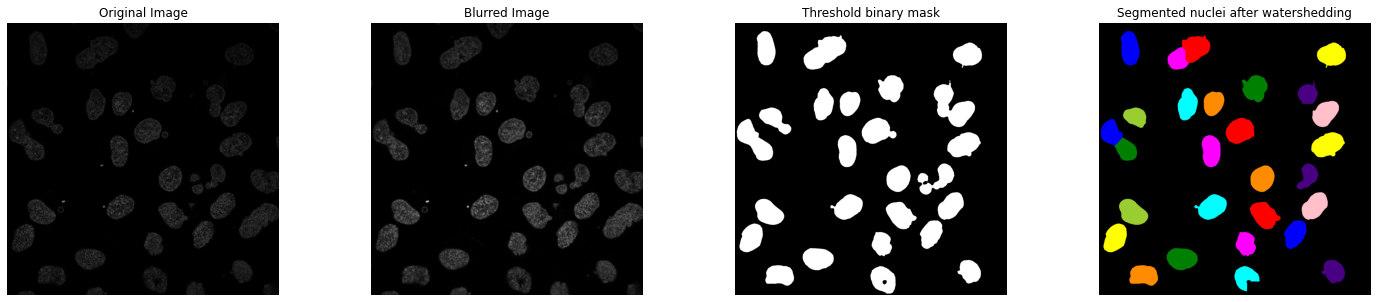

1802_wapl_dep_sor_si_16nm_rep2_pos16-23 #6.tif


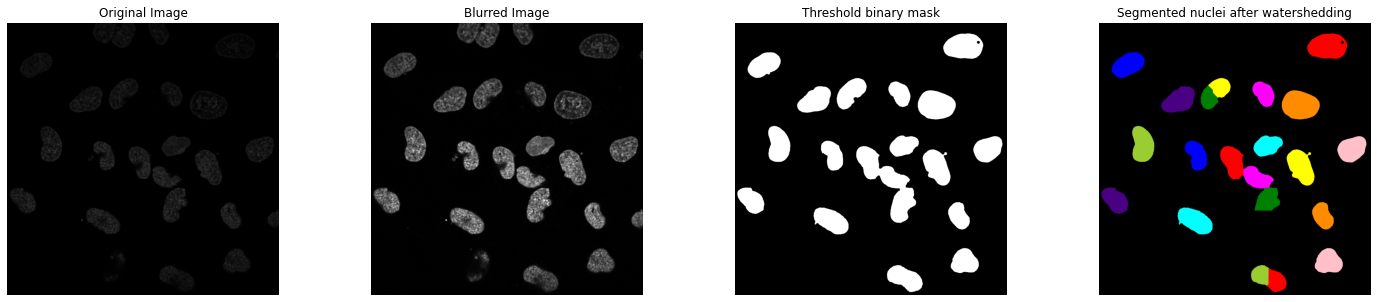

1802_wapl_dep_sor_si_16nm_rep2_pos16-23 #7.tif


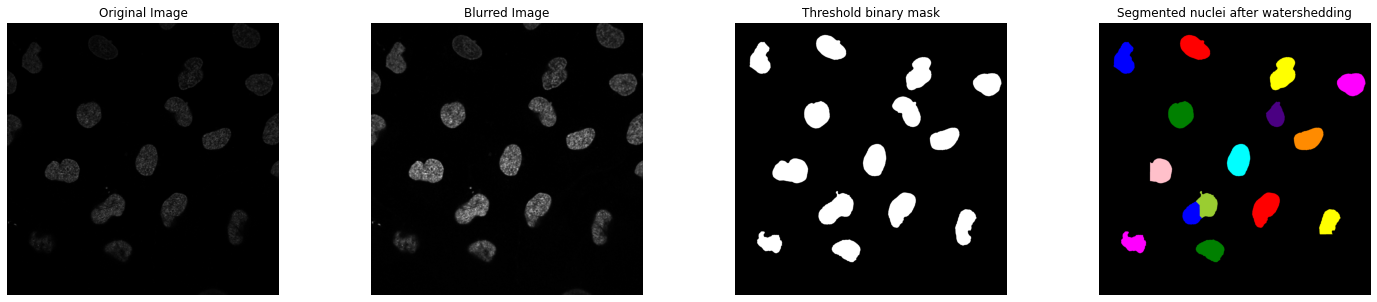

In [34]:
inpath = ( "/groups/gerlich/experiments/Experiments_005700/005765/tifs/1802_16nm_sor_si/")
os.chdir(inpath)
images = glob('*.tif', recursive=True)
result = threshold_field(images)

#data = io.imread("/groups/gerlich/experiments/Experiments_005200/005223/Images/Projections/short_g2_scc1_smc4/2108_zoom5_0_control_short_G2_cycB1_SMC4_Scc1_EGFP_Hoechst-02-64.czi #1.tif_registered.tif")

In [35]:
result

nuclear_area_microns  mean_hoechst  mean_sororin  total_hoechst  \
0             211.189734      9.017863      8.133713    1904.480099   
1             180.949911      9.765319      8.338564    1767.033617   
2             194.438070     10.171154      8.700552    1977.659473   
3             398.192600     11.837926     10.847037    4713.774625   
4             422.474279     11.517818      8.372311    4865.981734   
..                   ...           ...           ...            ...   
10            427.718843     19.426313     10.449821    8309.000155   
11            213.555027     20.947191     16.181372    4473.378013   
12            254.373798     12.442012      9.955862    3164.921830   
13            241.244924      8.892750      8.146282    2145.330808   
14            301.784451     13.242092      9.313293    3996.257479   

    total_nuclear_sororin  std_hoechst  std_sororin  coeff_variance_hoechst  \
0             1717.756678     7.614824     8.477147                0.844416   
1             1508.862376     8.130362     9.552138                0.832575   
2             1691.718493     8.202911     8.999424                0.806488   
3             4319.209806     9.039619    11.452107                0.763615   
4             3537.086226     8.916610     8.842344                0.774158   
..                    ...          ...          ...                     ...   
10            4469.585560    13.665441    12.345920                0.703450   
11            3455.613356    14.810406    18.870504                0.707035   
12            2532.510324    10.081248    11.818819                0.810259   
13            1965.249169     8.100045     8.829507                0.910859   
14            2810.606914    10.573980    10.534751                0.798513   

    coeff_variance_smc4       condition  
0              1.042223  16nm_sor_sirna  
1              1.145538  16nm_sor_sirna  
2              1.034351  16nm_sor_sirna  
3              1.055782  16nm_sor_sirna  
4              1.056141  16nm_sor_sirna  
..                  ...             ...  
10             1.181448  16nm_sor_sirna  
11             1.166187  16nm_sor_sirna  
12             1.187122  16nm_sor_sirna  
13             1.083870  16nm_sor_sirna  
14             1.131152  16nm_sor_sirna  

[971 rows x 10 columns]

In [57]:
# Testing thresholding on single image using cellpose and napari

# To do, use command line and cell pose to apply thresholding to a folder of cells

In [14]:
data = io.imread("/groups/gerlich/experiments/Experiments_005600/005606/images/tifs/2096_minus_dtag/2096_minus_dtag_stain_hoechst_scc1_pos1-6 #06.tif")
#mask = io.imread("/groups/gerlich/experiments/Experiments_005000/005003/TIFs_registered_background_subtracted_testing/WT_fully_noR/Rep1/1/slices/20/Mask.tif")
print("shape: {}".format(data.shape))
print("dtype: {}".format(data.dtype))
print("range: ({}, {})".format(data.min(), data.max()))

#print("m shape: {}".format(mask.shape))
#print("m dtype: {}".format(mask.dtype))
#print("m range: ({}, {})".format(mask.min(), mask.max()))

shape: (2, 1912, 1912)
dtype: uint8
range: (0, 255)


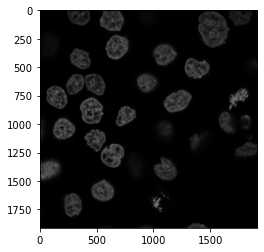

In [15]:
hoechst = data[0,:,:]
scc1 = data[1,:,:]
#wapl_ha = data[:,:,2]
display_slice(hoechst)
